## 1. 定义算法

策略网络中顺着策略梯度进行更新时，可能会因为步长太差，策略突然变差，TRPO算法就是在策略梯度算法和Actor-Critic算法的基础上进行的改进。TRPO在更新时候找到一个信任区域，使得策略更新时的性能可以得到一定的保证，使得回报函数单调不减。
配置和 DQN 基本一致，只是在模型定义的时候，在模型中加入了一些噪声参数。

### 1.1、 定义模型
这里分别定义了actor和critic的模型，基本都是由三层MLP组成。

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super(Critic,self).__init__()
        assert output_dim == 1 # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        probs = F.softmax(self.fc3(x),dim=1)
        return probs


/home/dingli/anaconda3/envs/joyrl_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2、定义经验回放

这里的经验回放具有一定容量，在收集到一个episode的时候才会进行更新，然后再清楚经验回放。经验回放的时候一般包涵两个功能或方法，一个是push，即将一个transition样本按顺序放到经验回放中，如果满了就把最开始放进去的样本挤掉；另外一个是sample，就是顺序采样或者随机采样出一个或者若干个（具体多少就是batch_size了）样本供D网络更新。

In [35]:
from collections import deque
import random
class ReplayBufferQue:
    def __init__(self, cfg):
        self.capacity = cfg.buffer_size # 经验回放的容量
        self.buffer = deque(maxlen=self.capacity)
    def push(self, exps: list):
        ''' 添加样本到经验池
        Args:
            trainsitions (tuple): _description_
        '''
        for exp in exps:
            self.buffer.append(exp)
    def sample(self, batch_size: int, sequential: bool = False):
        ''' 从经验池中随机采样小批量样本
        Args:
            batch_size (int): _description_
            sequential (bool, optional): _description_. Defaults to False.
        Returns:
            _type_: _description_
        '''
        if batch_size > len(self.buffer): # 如果小批量大于经验池的容量，则取经验池的容量
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return batch
        else:
            batch = random.sample(self.buffer, batch_size)
            return batch
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)


### 1.3、模型算法定义

这里根据前面的Actor和Critic搭建智能体agent，其中的动作采样是按照概率进行采样，模型更新即通过KL散度来衡量策略之间的距离，并通过线性搜索来满足KL散度限制。

In [36]:
import torch
import torch.optim as optim
import math
import numpy as np
import copy
from torch.distributions import Categorical,Normal

class TRPO:
    def __init__(self, actor, critic, memory, cfg) -> None:
        self.cfg = cfg
        self.gamma = cfg.gamma
        self.lmbda = cfg.lmbda  # GAE参数
        self.device = torch.device(cfg.device)
        
        self.sample_count = 0
        self.train_batch_size = cfg.train_batch_size
        self.alpha = cfg.alpha
        self.kl_constraint = cfg.kl_constraint 
        self.grad_steps = cfg.grad_steps
        self.search_steps = cfg.search_steps

        self.actor = actor
        self.critic = critic
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.cfg.critic_lr)
        self.memory = memory


    def sample_action(self,state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.detach().cpu().numpy().item()
    @torch.no_grad()
    def predict_action(self,state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.detach().cpu().numpy().item()

    """
        Modified from codes from https://hrl.boyuai.com/chapter/2/trpo%E7%AE%97%E6%B3%95/
    """
    def hessian_product_vector(self, states, old_action_dists, vector):
        # 计算hessian矩阵和向量的乘积
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        # 计算平均KL距离
        kl = torch.mean( torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))  
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])

        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector          

    def conjugate_gradient(self, grad, states, old_action_dists, grad_steps):  
        # 使用共轭梯度法
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(grad_steps):  
            Hp = self.hessian_product_vector(states, old_action_dists, p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            betta = new_rdotr / rdotr
            p = r + betta * p
            rdotr = new_rdotr
        return x        

    def compute_obj(self, states, actions, advantage, old_log_probs, actor): 
        ## 计算策略目标
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        obj = torch.mean(ratio * advantage)
        return obj

    def line_search(self, states, actions, advantage, old_log_probs, old_action_dist, max_vec, search_steps):
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        old_obj = self.compute_obj(states, actions, advantage, old_log_probs, self.actor)

        for i in range(search_steps): 
            coef = self.alpha ** i
            new_para = old_para + coef * max_vec; new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(new_para, new_actor.parameters())
            new_action_dist = torch.distributions.Categorical(new_actor(states))
            kl_div = torch.mean(torch.distributions.kl.kl_divergence(old_action_dist,new_action_dist))
            new_obj = self.compute_obj(states, actions, advantage,old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def update_policy(self, states, actions, old_action_dist, old_log_probs, advantage, grad_steps, search_steps):  
        ## 算共轭梯度
        surrogate_obj = self.compute_obj(states, actions, advantage, old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dist, grad_steps)

        Hd = self.hessian_product_vector(states, old_action_dist, descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hd) + 1e-8))
        # 线性搜索参数
        new_para = self.line_search(states, actions, advantage, old_log_probs, old_action_dist, descent_direction * max_coef, search_steps)  
        torch.nn.utils.convert_parameters.vector_to_parameters(new_para, self.actor.parameters())  


    def update(self):
        exps = self.memory.sample(len(self.memory), sequential=True)
        # convert to tensor
        state_batch = torch.tensor(np.array([exp.state for exp in exps]), device=self.device, dtype=torch.float32) # shape:[train_batch_size,n_states]
        action_batch = torch.tensor(np.array([exp.action for exp in exps]), device=self.device, dtype=torch.long).unsqueeze(dim=1) # shape:[train_batch_size,1]
        reward_batch = torch.tensor(np.array([exp.reward for exp in exps]), device=self.device, dtype=torch.float32).unsqueeze(dim=1) # shape:[train_batch_size,1]
        next_state_batch = torch.tensor(np.array([exp.next_state for exp in exps]), device=self.device, dtype=torch.float32) # shape(batchsize,n_states)
        done_batch = torch.tensor(np.array([exp.done for exp in exps]), device=self.device, dtype=torch.float32).unsqueeze(dim=1) # shape:[train_batch_size,1]


        target = reward_batch + self.gamma * self.critic(next_state_batch) * (1 - done_batch)    
        td_delta = target - self.critic(state_batch)    

        ## calculate the advantage
        td_delta = td_delta.cpu().detach().numpy()
        advantage_list = []
        advantage_value = 0.0
        for delta in td_delta[::-1]:
            advantage_value = self.gamma * self.lmbda * advantage_value + delta
            advantage_list.append(advantage_value)
        advantage_list.reverse()
        advantage = torch.tensor(advantage_list, dtype=torch.float).to(self.device)
        # calculate the advantage

        old_log_probs = torch.log(self.actor(state_batch).gather(dim=1, index=action_batch)).detach()
        old_action_dist = torch.distributions.Categorical(self.actor(state_batch).detach())
        
        critic_loss = F.mse_loss(self.critic(state_batch), target.detach())
        critic_loss = torch.mean( critic_loss )
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # 更新策略函数
        self.update_policy(state_batch, action_batch, old_action_dist, old_log_probs, \
            advantage, self.grad_steps, self.search_steps)        


## 2、 定义训练

In [45]:
class Exp():
    def __init__(self, state=None, action=None, reward=None, next_state=None, done=None, **kwargs) -> None:
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done
        self.info = kwargs.get('info', None)

def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, done, info = env.step(action)  # 更新环境，返回transition
            exp = [Exp(state = state, action = action, reward = reward, next_state = next_state, done = done, info = info)]
            agent.memory.push(exp) # 保存transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
            
        agent.update()  # update agent
        agent.memory.clear()
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [46]:
import gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    if cfg.seed !=0:
        all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")

    cfg.n_actions = env.action_space.n  ## set the env action space

    actor = Actor(n_states, n_actions, hidden_dim = cfg.actor_hidden_dim).to(cfg.device)
    critic = Critic(n_states, 1, hidden_dim=cfg.critic_hidden_dim).to(cfg.device)
    memory = ReplayBufferQue(cfg)
    agent = TRPO(actor,critic,memory,cfg)
    return env,agent

## 4、设置参数

In [55]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config():
    def __init__(self) -> None:
        self.env_name = "CartPole-v1" # 环境名字
        self.new_step_api = True # 是否用gym的新api
        self.wrapper = None 
        self.render = False 
        self.algo_name = "TRPO" # 算法名字
        self.mode = "train" # train or test
        self.seed = 1 # 随机种子
        self.device = "cuda" # device to use
        self.train_eps = 200 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.eval_eps = 10 # 评估的回合数
        self.eval_per_episode = 5 # 每个回合的评估次数
        self.max_steps = 200 # 每个回合的最大步数
        self.load_checkpoint = False
        self.load_path = "tasks" # 加载模型的路径
        self.show_fig = False # 是否展示图片
        self.save_fig = True # 是否存储图片


        # 设置epsilon值
        self.lmbda = 0.95 #
        self.gamma = 0.98 
        self.alpha = 0.5
        self.buffer_size = 100000 # 经验回放的buffer大小
        self.actor_hidden_dim = 128
        self.critic_hidden_dim = 128
        self.critic_lr = 0.02
        self.train_batch_size = 64
        self.kl_constraint = 0.0005
        self.search_steps = 15
        self.grad_steps = 10     
        
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()


## 5、开始训练

状态空间维度：4，动作空间维度：2
开始训练！
回合：10/200，奖励：23.00
回合：20/200，奖励：18.00
回合：30/200，奖励：41.00
回合：40/200，奖励：86.00
回合：50/200，奖励：52.00
回合：60/200，奖励：47.00
回合：70/200，奖励：197.00
回合：80/200，奖励：200.00
回合：90/200，奖励：200.00
回合：100/200，奖励：200.00
回合：110/200，奖励：200.00
回合：120/200，奖励：200.00
回合：130/200，奖励：200.00
回合：140/200，奖励：200.00
回合：150/200，奖励：200.00
回合：160/200，奖励：200.00
回合：170/200，奖励：200.00
回合：180/200，奖励：200.00
回合：190/200，奖励：200.00
回合：200/200，奖励：200.00
完成训练！


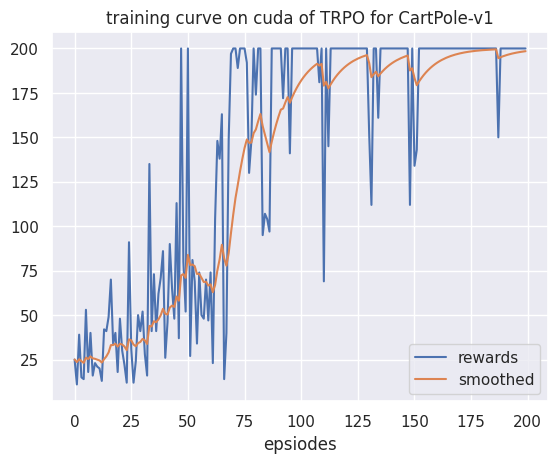

开始测试！
回合：1/20，奖励：200.00
回合：2/20，奖励：200.00
回合：3/20，奖励：200.00
回合：4/20，奖励：200.00
回合：5/20，奖励：200.00
回合：6/20，奖励：200.00
回合：7/20，奖励：200.00
回合：8/20，奖励：200.00
回合：9/20，奖励：200.00
回合：10/20，奖励：200.00
回合：11/20，奖励：200.00
回合：12/20，奖励：200.00
回合：13/20，奖励：200.00
回合：14/20，奖励：200.00
回合：15/20，奖励：200.00
回合：16/20，奖励：200.00
回合：17/20，奖励：200.00
回合：18/20，奖励：200.00
回合：19/20，奖励：200.00
回合：20/20，奖励：200.00
完成测试


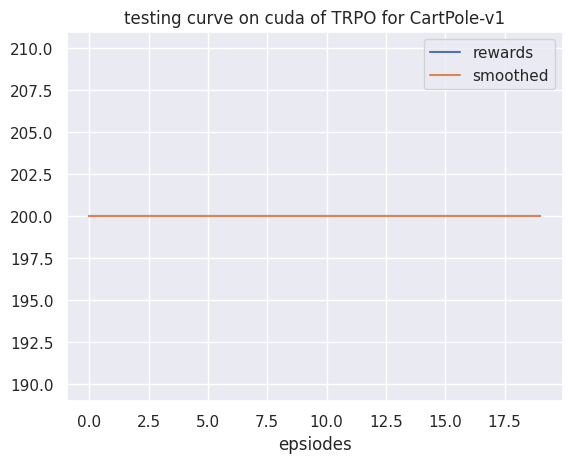

In [56]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果